##### Copyright 2019 The TensorFlow Authors.

# Transfer Learning Using Pretrained ConvNets

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/beta/tutorials/images/transfer_learning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/r2/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/r2/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/r2/tutorials/images/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

In this tutorial you will learn how to classify cats vs dogs images by using transfer learning from a pre-trained network.


A **pre-trained model** is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as it is, or use **transfer learning** to customize this model to a given task.

The intuition behind transfer learning is that if a model trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch training a large model on a large dataset.

In this notebook, you will try two ways to customize a pretrained model:

1. **Feature Extraction**: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for our dataset.

  You do not need to (re)train the entire model.  The base convolutional network already contains features that are generically useful for classifying pictures. However, the final, classification part of the pretrained model is specific to original classification task, and subsequently specific to the set of classes on which the model was trained.

2. **Fine-Tuning**: Unfreezing a few of the top layers of a frozen model base and jointly training both the newly-added classifier layers and the last layers of the base model. This allows us to "fine tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

You will follow the general machine learning workflow.

1. Examine and understand the data
2. Build an input pipeline, in this case using Keras `ImageDataGenerator`
3. Compose our model
  * Load in our pretrained base model (and pretrained weights)
  * Stack our classification layers on top
4. Train our model
5. Evaluate model


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import numpy as np

import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

keras = tf.keras
print(tf.__version__)

2.0.0-rc0


## Data preprocessing

### Data download

Use [TensorFlow Datasets](http://tensorflow.org/datasets) to load the cats and dogs dataset.

This `tfds` package is the easiest way to load pre-defined data. If you have your own data, and are interested in importing using it with TensorFlow see [loading image data](../load_data/images.ipynb)


In [3]:
!pip install tensorflow-datasets

     |████████████████████████████████| 2.3MB 2.8MB/s eta 0:00:01
     |████████████████████████████████| 61kB 17.6MB/s eta 0:00:01
     |████████████████████████████████| 61kB 11.3MB/s eta 0:00:01
     |████████████████████████████████| 153kB 22.8MB/s eta 0:00:01
     |████████████████████████████████| 440kB 25.6MB/s eta 0:00:01
     |████████████████████████████████| 829kB 19.6MB/s eta 0:00:01
     |████████████████████████████████| 143kB 21.8MB/s eta 0:00:01
     |████████████████████████████████| 153kB 23.2MB/s eta 0:00:01
     |████████████████████████████████| 163kB 44.6MB/s eta 0:00:01
  Created wheel for promise: filename=promise-2.2.1-cp36-none-any.whl size=23744 sha256=bc5cae1a34cbdd8f08271e53cb3819a485bedf7f8d8c4ebd529ff64ebcce9d5b
  Stored in directory: /root/.cache/pip/wheels/92/84/9f/75e2235effae0e1c5a5c0626a503e532bbffcb7e79e672b606
  Created wheel for dill: filename=dill-0.3.0-cp36-none-any.whl size=79804 sha256=a97e62ab7670a2a766a7a5c37e24c950cb9d6bf74db2d43efaa1d1d63a

In [4]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

The `tfds.load` method downloads and caches the data, and returns a `tf.data.Dataset` object. These objects provide powerful, efficient methods for manipulating data and piping it into your model.

Since `"flower"` doesn't define standard splits, use the subsplit feature to divide it into (train, validation, test) with 80%, 10%, 10% of the data respectively.

In [3]:
import tensorflow_datasets as tfds

SPLIT_WEIGHTS = (8, 1, 1)
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)

(raw_train, raw_validation, raw_test), metadata = tfds.load('tf_flowers', split=list(splits),
                                                  with_info=True, as_supervised=True)

The resulting `tf.data.Dataset` objects contain `(image, label)` pairs. Where the images have variable shape and 3 channels, and the label is a scalar.

In [4]:
print(raw_train)
print(raw_validation)
print(raw_test)

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


Show the first two images and labels from the training set:

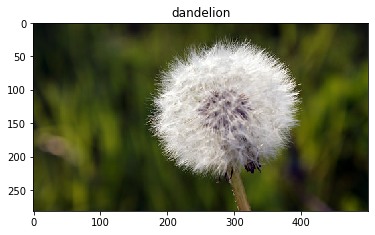

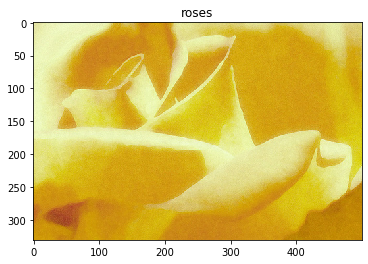

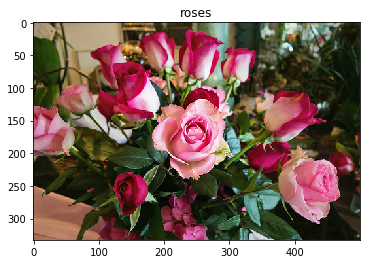

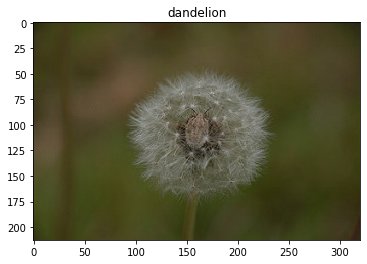

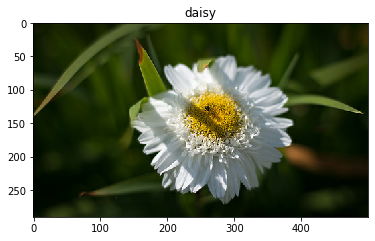

In [7]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(5):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

In [8]:
images = []
labels = []
for image, label in raw_train.take(5):
    images.append(image)
    labels.append(label)

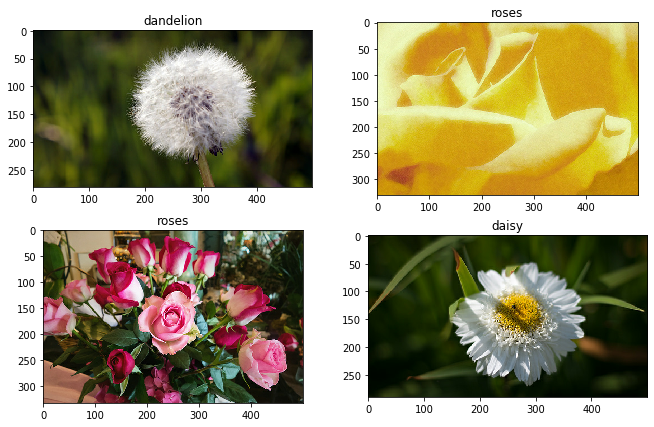

In [9]:
#fig = plt.figure()
fig , axs = plt.subplots(nrows=2, ncols=2)
axs[0, 0].imshow(images[0])
axs[0, 0].set_title(get_label_name(labels[0]))
axs[0, 1].imshow(images[1])
axs[0, 1].set_title(get_label_name(labels[1]))

axs[1, 0].imshow(images[2])
axs[1, 0].set_title(get_label_name(labels[2]))

axs[1, 1].imshow(images[4])
axs[1, 1].set_title(get_label_name(labels[4]))


fig.set_size_inches(w=11,h=7)

In [10]:
metadata.features["label"].names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [11]:
raw_train.take(4)

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

### Format the Data

Use the `tf.image` module to format the images for the task.

Resize the images to a fixes input size, and rescale the input channels to a range of `[-1,1]`

<!-- TODO(markdaoust): fix the keras_applications preprocessing functions to work in tf2 -->

In [5]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

Apply this function to each item in the dataset using the map method:

In [9]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [10]:
len(list(test))

360

Now shuffle and batch the data.

In [11]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 300

In [12]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

Inspect a batch of data:

In [16]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([32, 160, 160, 3])

In [17]:
train_batches

<BatchDataset shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.int64)>

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset of 1.4M images and 1000 classes of web images. ImageNet has a fairly arbitrary research training dataset with categories like `jackfruit` and `syringe`, but this base of knowledge will help us tell apart cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. Obviously, the very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.  Instead, you will follow the common practice to instead depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck features retain much generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [18]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 5s 1us/step


This feature extractor converts each `160x160x3` image to a `5x5x1280` block of features. See what it does to the example batch of images:

In [19]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


## Feature extraction
You will freeze the convolutional base created from the previous step and use that as a feature extractor, add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base
It's important to freeze the convolutional based before you compile and train the model. By freezing (or setting `layer.trainable = False`), you prevent the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to `False` will freeze all the layers.

In [20]:
base_model.trainable = False

In [21]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [22]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value.  Positive numbers predict class 1, negative numbers predict class 0.

In [23]:
prediction_layer = keras.layers.Dense(5, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


Now stack the feature extractor, and these two layers using a `tf.keras.Sequential` model:

In [28]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

### Compile the model

You must compile the model before training it.  Since there are two classes, use a binary cross-entropy loss.

In [29]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


The 2.5M parameters in MobileNet are frozen, but there are 1.2K _trainable_ parameters in the Dense layer.  These are divided between two `tf.Variable` objects, the weights and biases.

In [31]:
len(model.trainable_variables)

2

### Train the model

After training for 10 epochs, you should see ~96% accuracy.

<!-- TODO(markdaoust): delete steps_per_epoch in TensorFlow r1.14/r2.0 -->

In [32]:
num_train, num_val, num_test = (
  metadata.splits['train'].num_examples*weight/10
  for weight in SPLIT_WEIGHTS
)

In [33]:
num_train, BATCH_SIZE

(2936.0, 32)

In [34]:
initial_epochs = 10
steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps = 12

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

12/12 [==============================] - 3s 232ms/step - loss: 1.9050 - accuracy: 0.2194


In [35]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.91
initial accuracy: 0.22


In [36]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/10
93/93 [==============================] - 17s 188ms/step - loss: 1.6495 - accuracy: 0.2990 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
93/93 [==============================] - 13s 135ms/step - loss: 1.2571 - accuracy: 0.5075 - val_loss: 1.1298 - val_accuracy: 0.5528
Epoch 3/10
93/93 [==============================] - 13s 137ms/step - loss: 0.9983 - accuracy: 0.6427 - val_loss: 0.9849 - val_accuracy: 0.6417
Epoch 4/10
93/93 [==============================] - 13s 135ms/step - loss: 0.8240 - accuracy: 0.7125 - val_loss: 0.9057 - val_accuracy: 0.6750
Epoch 5/10
93/93 [==============================] - 12s 134ms/step - loss: 0.7225 - accuracy: 0.7573 - val_loss: 0.8355 - val_accuracy: 0.7056
Epoch 6/10
93/93 [==============================] - 12s 132ms/step - loss: 0.6477 - accuracy: 0.7885 - val_loss: 0.8266 - val_accuracy: 0.7167
Epoch 7/10
93/93 [==============================] - 12s 133ms/step - loss: 0.5973 - accuracy: 0.8102 - val_loss: 0.8098 - val_accuracy

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

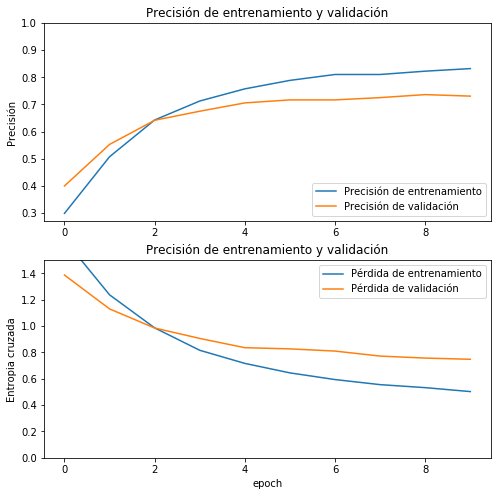

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Precisión de entrenamiento')
plt.plot(val_acc, label='Precisión de validación')
plt.legend(loc='lower right')
plt.ylabel('Precisión')
plt.ylim([min(plt.ylim()),1])
plt.title('Precisión de entrenamiento y validación')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Pérdida de entrenamiento')
plt.plot(val_loss, label='Pérdida de validación')
plt.legend(loc='upper right')
plt.ylabel('Entropia cruzada')
plt.ylim([0,1.5])
plt.title('Precisión de entrenamiento y validación')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Data augmentation

In [63]:
def plot_images(dataset, n_images, samples_per_image):
    output = np.zeros((32 * n_images, 32 * samples_per_image, 3))

    row = 0
    for images in dataset.repeat(samples_per_image).batch(n_images):
        output[:, row*32:(row+1)*32] = np.vstack(images.numpy())
        row += 1

    plt.figure()
    plt.imshow(output)
    plt.show()

In [116]:
def flip(x: tf.Tensor, label:str):
    """Flip augmentation
    Args:
        x: Image to flip
    Returns:
        Augmented image
    """
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)

    return x , label

In [132]:
def rotate(x: tf.Tensor, label ):
    """Rotation augmentation
    Args:
        x: Image
    Returns:
        Augmented image
    """
    return tf.compat.v1.contrib.image.rotate(x, 30 ) , label

In [145]:
def zoom(x: tf.Tensor, label):
    """Zoom augmentation
    Args:
        x: Image
    Returns:
        Augmented image
    """

    # Generate 20 crop settings, ranging from a 1% to 20% crop.
    scales = list(np.arange(0.8, 1.0, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize([img], boxes=boxes, box_indices=np.zeros(len(scales)), crop_size=(IMG_SIZE, IMG_SIZE))
        # Return a random crop
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]


    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

    # Only apply cropping 50% of the time
    return tf.cond(choice < 0.5, lambda: x, lambda: random_crop(x)) , label

In [149]:
def color(x: tf.Tensor, label):
    """Color augmentation
    Args:
        x: Image
    Returns:
        Augmented image
    """
    x = tf.image.random_saturation(x, 0.6, 1.6)
    x = tf.image.random_brightness(x, 0.05)
    x = tf.image.random_contrast(x, 0.7, 1.3)
    return x, label

In [68]:
augmentations = [flip, zoom, rotate]

In [151]:
train2 = train.map(flip, num_parallel_calls=4)

In [152]:
train2 = train2.map(zoom, num_parallel_calls=4)

In [153]:
train2 = train2.map(color, num_parallel_calls=4)

## Fine tuning
In our feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic features maps to features associated specifically to our dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features which generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [38]:
base_model.trainable = True

In [39]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  155


### Compile the model

Compile the model using a much lower training rate.

In [40]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 1,868,997
Non-trainable params: 395,392
_________________________________________________________________


In [42]:
len(model.trainable_variables)

58

### Continue Train the model

If you trained to convergence earlier, this will get you a few percent more accuracy.

In [43]:
initial_epochs = 10
fine_tune_epochs = 40
total_epochs =  initial_epochs + fine_tune_epochs
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch = initial_epochs,
                         validation_data=validation_batches,
                        callbacks = [callback]
                        )

Epoch 11/50
93/93 [==============================] - 23s 249ms/step - loss: 0.4517 - accuracy: 0.8468 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 12/50
93/93 [==============================] - 14s 146ms/step - loss: 0.3710 - accuracy: 0.8814 - val_loss: 0.5823 - val_accuracy: 0.7917
Epoch 13/50
93/93 [==============================] - 14s 145ms/step - loss: 0.3069 - accuracy: 0.9047 - val_loss: 0.5237 - val_accuracy: 0.8056
Epoch 14/50
93/93 [==============================] - 14s 146ms/step - loss: 0.2638 - accuracy: 0.9278 - val_loss: 0.4801 - val_accuracy: 0.8167
Epoch 15/50
93/93 [==============================] - 14s 148ms/step - loss: 0.2340 - accuracy: 0.9302 - val_loss: 0.4581 - val_accuracy: 0.8167
Epoch 16/50
93/93 [==============================] - 14s 148ms/step - loss: 0.2028 - accuracy: 0.9454 - val_loss: 0.4342 - val_accuracy: 0.8222
Epoch 17/50
93/93 [==============================] - 14s 147ms/step - loss: 0.1786 - accuracy: 0.9458 - val_loss: 0.4177 - val_a

Let's take a look at the learning curves of the training and validation accuracy/loss, when fine tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.


After fine tuning the model nearly reaches 98% accuracy.

In [44]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

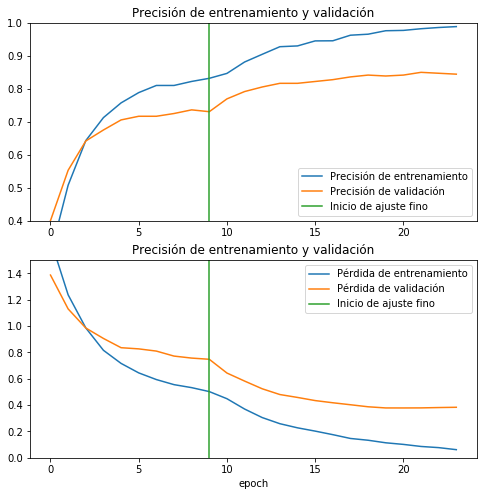

In [47]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Precisión de entrenamiento')
plt.plot(val_acc, label='Precisión de validación')
plt.ylim([0.4, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Inicio de ajuste fino')
plt.legend(loc='lower right')
plt.title('Precisión de entrenamiento y validación')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Pérdida de entrenamiento')
plt.plot(val_loss, label='Pérdida de validación')
plt.ylim([0, 1.5])
plt.plot([initial_epochs-1,initial_epochs-1],
        plt.ylim(), label='Inicio de ajuste fino')
plt.legend(loc='upper right')
plt.title('Precisión de entrenamiento y validación')
plt.xlabel('epoch')
plt.show()

In [52]:
model.evaluate(test_batches)

12/12 [==============================] - 1s 99ms/step - loss: 0.3521 - accuracy: 0.8833


[0.3520677412549655, 0.8833333]

In [49]:
model.save('flower_MobileNetV2_01.h5')

In [3]:
new_model = keras.models.load_model('flower_MobileNetV2_01.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [4]:
new_model.save('FlowerModel/my_model') 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: FlowerModel/my_model/assets


In [26]:
def re_format_example(image):
    image = (image + 1 ) *127.5
    return image

In [72]:
print(test)

<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>


In [33]:
predictions = []
for image, label in test.take(len(list(test))):
    img = (np.expand_dims(image,0))
    predictions_single = new_model.predict(img)
    predictions.append(np.around(predictions_single, decimals = 3))

   

[array([[1., 0., 0., 0., 0.]], dtype=float32),
 array([[0.001, 0.982, 0.016, 0.001, 0.   ]], dtype=float32),
 array([[0.076, 0.656, 0.25 , 0.008, 0.011]], dtype=float32),
 array([[0.999, 0.   , 0.   , 0.001, 0.   ]], dtype=float32),
 array([[0.001, 0.101, 0.143, 0.003, 0.752]], dtype=float32),
 array([[0.   , 0.002, 0.995, 0.   , 0.002]], dtype=float32),
 array([[0.001, 0.005, 0.082, 0.   , 0.912]], dtype=float32),
 array([[0.002, 0.394, 0.561, 0.033, 0.009]], dtype=float32),
 array([[0.999, 0.   , 0.   , 0.   , 0.   ]], dtype=float32),
 array([[0., 0., 0., 1., 0.]], dtype=float32),
 array([[0.999, 0.001, 0.   , 0.   , 0.   ]], dtype=float32),
 array([[0.996, 0.   , 0.   , 0.004, 0.   ]], dtype=float32),
 array([[0.   , 0.   , 0.998, 0.002, 0.   ]], dtype=float32),
 array([[0.81 , 0.189, 0.   , 0.001, 0.   ]], dtype=float32),
 array([[0.001, 0.009, 0.   , 0.99 , 0.   ]], dtype=float32),
 array([[0.718, 0.269, 0.01 , 0.   , 0.003]], dtype=float32),
 array([[0.009, 0.004, 0.964, 0.009, 0

In [39]:
array_pred = []
for i in range(len(predictions)):
    array_pred.append(np.argmax(predictions[i]))

In [ ]:
for i in range(len(predictions)):
    if label != array_pred

In [47]:
labels_arr = []
images_arr = []
for image, label in raw_test.take(len(list(test))):
    labels_arr.append(label)
    images_arr.append(image)

In [65]:
wrong_predictions = []
for i in range(len(images_arr)):
    if labels_arr[i] !=  array_pred[i] :
        wrong_predictions.append([images_arr[i] , labels_arr[i], array_pred[i]])

In [66]:
len(wrong_predictions)

42

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


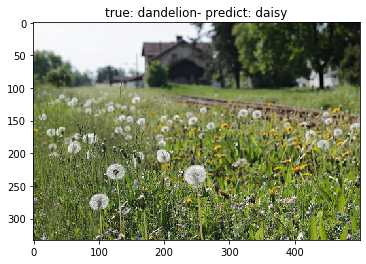

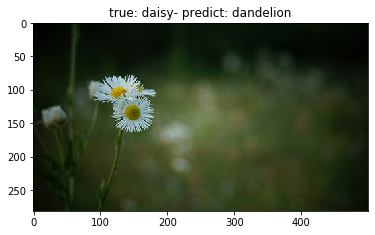

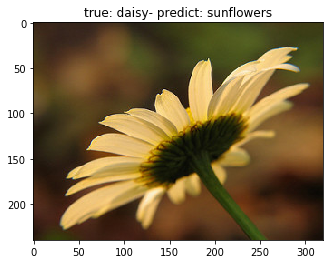

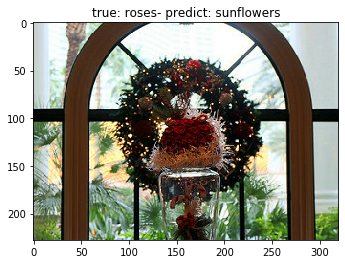

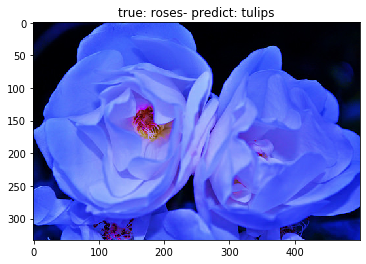

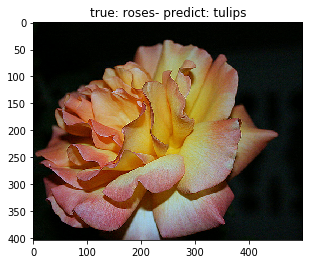

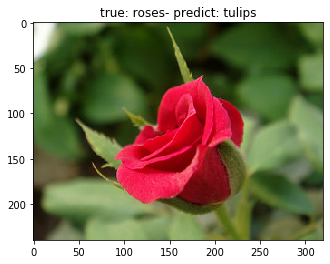

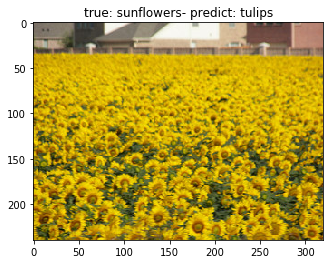

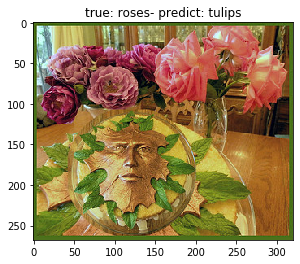

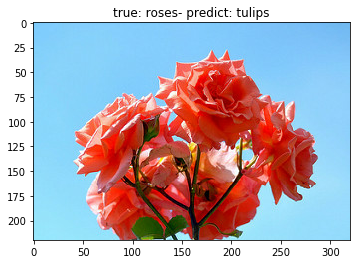

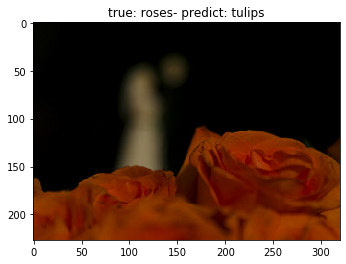

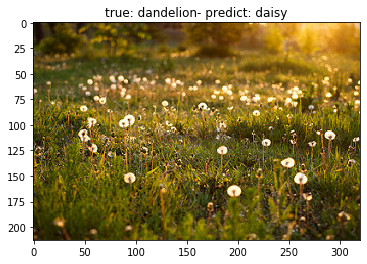

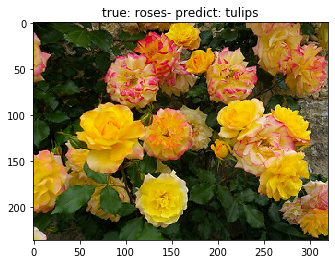

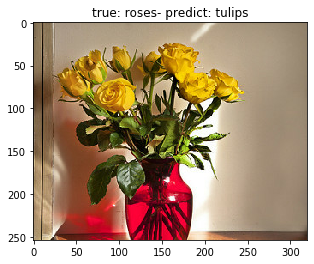

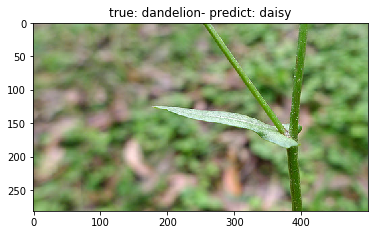

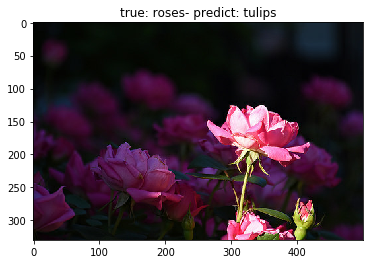

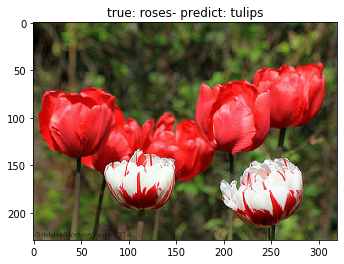

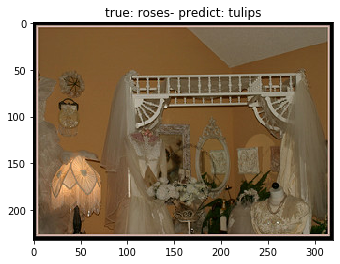

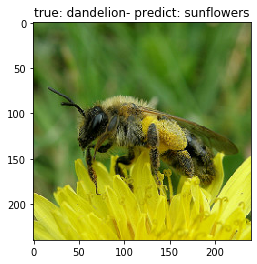

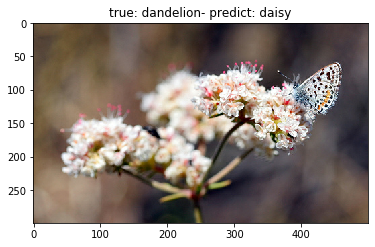

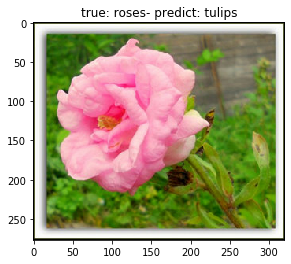

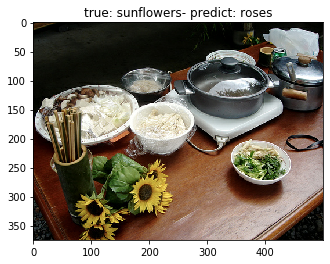

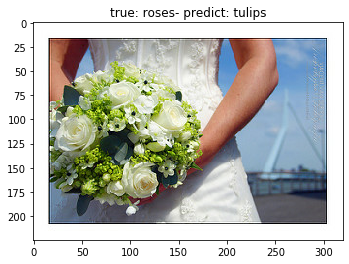

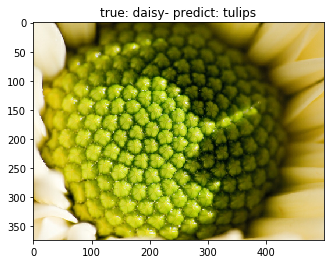

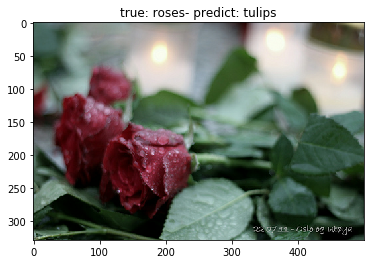

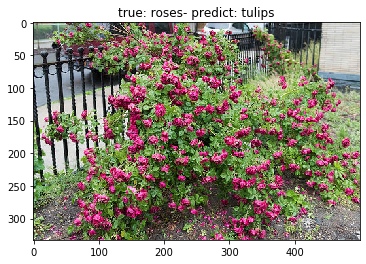

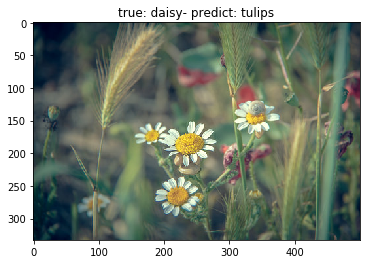

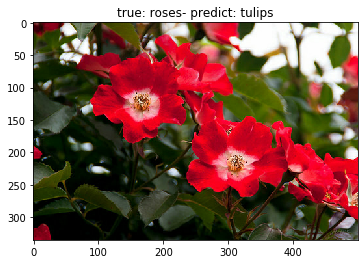

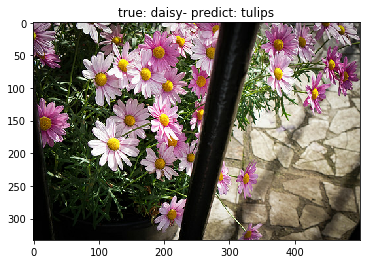

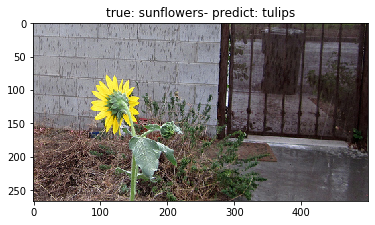

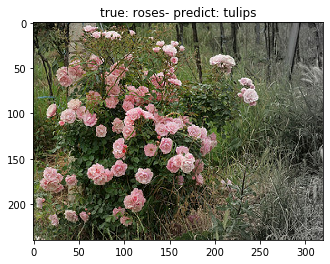

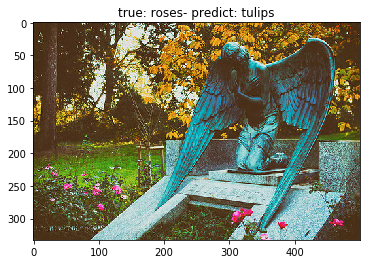

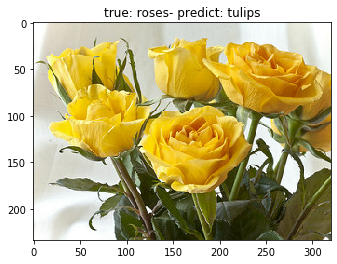

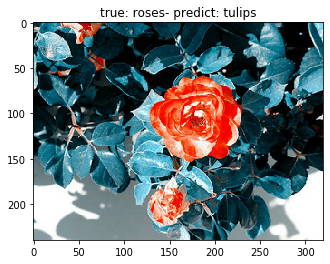

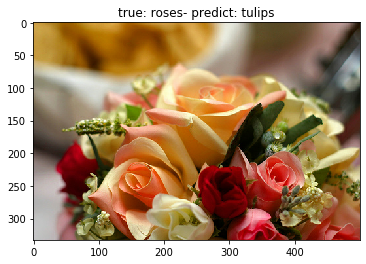

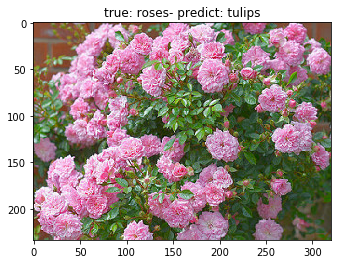

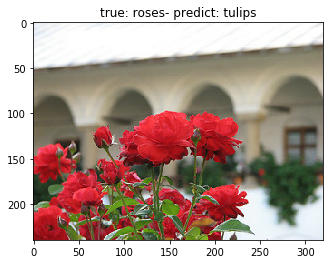

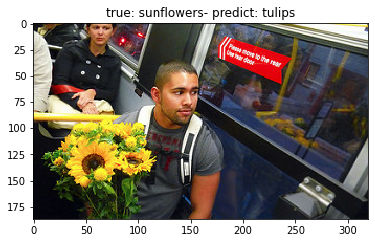

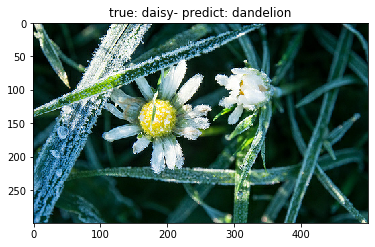

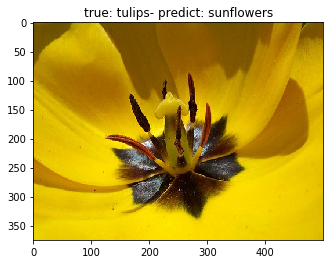

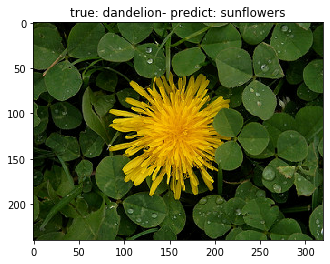

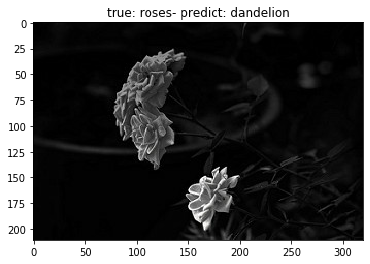

In [138]:
for i in range(len(wrong_predictions)):
    img, true, predict = wrong_predictions[i]
    plt.figure()
    plt.imshow(img)
    title_str = "true: " + get_label_name(true) + "- predict: " + get_label_name(predict)
    plt.title(title_str)

In [137]:
!pip install sklearn

In [139]:
from sklearn.metrics import confusion_matrix
confusion =confusion_matrix(labels_arr,array_pred)
categorias =  ['Diente de león', 'Margarita', 'Tulipanes', 'Girasoles', 'Rosas']

In [176]:
with open('confusion_matrix.txt', 'w') as f:
    f.write(np.array2string(confusion))

## Summary:

* **Using a pre-trained model for feature extraction**:  When working with a small dataset, it is common to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training.
In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

* **Fine-tuning a pre-trained model**: To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning.
In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.
